# Gaussian Process Classification

### Classification

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \{+1, -1\} \right \}_{i = 1}^n$ is given.  

Assumption:
$$
p(y = +1 \; | \; x) = \sigma(f(x)) = \pi(x),
$$
where latent function $f(x)$ is a realization of Gaussian Process.

The probabilistic prediction has the form:
$$
\pi_* = p(y_* \; | \; X, \mathbf{y}, x_*) = \int \sigma(f_*) p(f_* \; | \; X, \mathbf{y}, x_*) df_*,
$$
$$
p(f_* \; | \; X, \mathbf{y}, x_*) = \int p(f_* \; | \; X, x_*, \mathbf{f}) p(\mathbf{f} \; | \; X, \mathbf{y}) d\mathbf{f},
$$
where $p(\mathbf{f} \; |\; X, \mathbf{y}) = \dfrac{p(\mathbf{y} | X, \mathbf{f}) p(\mathbf{f} | X)}{p(\mathbf{y} | X)}$ is the posterior over the latent variables.

*Both integrals are intractable.*

We need to use approximation technique like Laplace approximation or Expectation Propagation.

In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def cylinder(x):
    y = (1 / 7.0 - (x[:, 0] - 0.5)**2 - (x[:, 1] - 0.5)**2) > 0
    
    return y

In [3]:
np.random.seed(42)
x = np.random.rand(40, 2)
y = cylinder(x)

In [12]:
x_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
y_grid = cylinder(np.hstack((x_grid[0].reshape(-1, 1), x_grid[1].reshape(-1, 1)))).reshape(x_grid[0].shape)

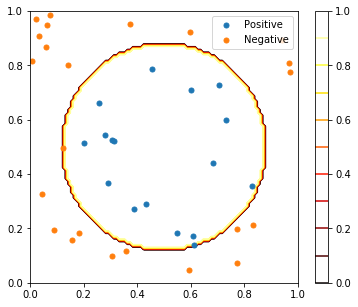

In [14]:
positive_idx = y == 1
plt.figure(figsize=(6, 5))
plt.plot(x[positive_idx, 0], x[positive_idx, 1], '.', markersize=10, label='Positive')
plt.plot(x[~positive_idx, 0], x[~positive_idx, 1], '.', markersize=10, label='Negative')
im = plt.contour(x_grid[0], x_grid[1], y_grid, 10, cmap=cm.hot)

plt.colorbar(im)
plt.legend()
plt.show()

 /home/wonchul/.virtualenvs/p3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/wonchul/.virtualenvs/p3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


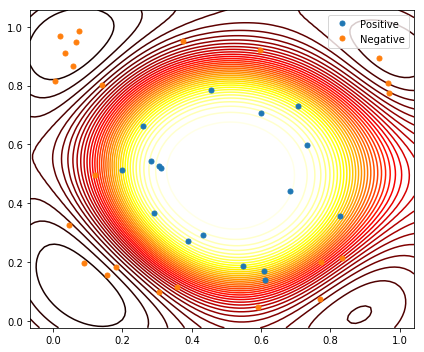

In [15]:
kernel = GPy.kern.RBF(input_dim=2, variance=1, lengthscale=0.2, ARD=True)
model = GPy.models.GPClassification(x, y.reshape(-1, 1), kernel=kernel)
model.optimize()

positive_idx = y == 1

model.plot(levels=40, resolution=80, plot_data=False, figsize=(6, 5))
plt.plot(x[positive_idx, 0], x[positive_idx, 1], '.', markersize=10, label='Positive')
plt.plot(x[~positive_idx, 0], x[~positive_idx, 1], '.', markersize=10, label='Negative')
plt.legend()
plt.show()

In [ ]:
# make lengthscale smaller
model.rbf.lengthscale = [0.05, 0.05]

positive_idx = y == 1

model.plot(levels=40, resolution=80, plot_data=False, figsize=(6, 5))
plt.plot(x[positive_idx, 0], x[positive_idx, 1], '.', markersize=10, label='Positive')
plt.plot(x[~positive_idx, 0], x[~positive_idx, 1], '.', markersize=10, label='Negative')
plt.legend()
plt.show()

## More complex probabilistic models

We have to deal with even more complex models in Industrial engineering.

**Example (by CERN, Yandex and HSE):**
We need to deal with magnet that tries to catch as much particles as possible.
In this case 
$$
y \sim Pois(f(\mathbf{x})), 
$$
so $y$ is a Poisson random variable with parameter $f(\mathbf{x})$ that depends on configuration $\mathbf{x}$ of the magnet. 

In this case we need to do inference for a more compex probabilistic model based on Gaussian process in a way similar to presented above for classification.
As the model in most cases is analyticaly intractable, we are required to do approximation inference.

![magnet](images/magnet.png)



In [ ]:
# to see the covariance function information
kernel = GPy.kern.RBF(1)
print(kernel)

# and plot the covariance fucntion using plot()
kernel.plot()

### Heaviside function

The most popular covariance function is RBF. However, not all the functions can be modelled using RBF covariance function. For example, approximations of functions with large gradients or discontinuities will suffer from oscillations.

In [ ]:
def heaviside(x):
    return np.asfarray(x > 0)

x = np.linspace(-1, 1, 100)
y = heaviside(x)
plt.figure(figsize=(5, 3))
plt.plot(points, values)
plt.xlabel('Points')
plt.ylabel('Values')
plt.tight_layout()

In [ ]:
np.random.seed(42)
points = np.random.rand(30, 1) * 2 - 1
values = heaviside(points)

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

model = GPy.models.GPRegression(points, values, kernel)
model.optimize()
print(model)

model.plot(figsize=(7, 6))
plt.ylim([-0.2, 1.2])
plt.tight_layout()

For Heavised function and other discontinuous functions puer RBF covariance is not suitable.

### Covariance functions in GPy

Popular covariance functions: `Exponential`, `Matern32`, `Matern52`, `RatQuad`, `Linear`, `StdPeriodic`. 

* Exponential:
$$
k(x, x') = \sigma^2 \exp \left (-\frac{r}{l} \right), \quad r = \|x - x'\|
$$

* Matern32
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{3}\frac{r}{l} \right )\exp \left (-\sqrt{3}\frac{r}{l} \right )
$$

* Matern52
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{5}\frac{r}{l} + \frac{5}{3}\frac{r^2}{l^2} \right ) \exp \left (-\sqrt{5}\frac{r}{l} \right )
$$

* RatQuad
$$
k(x, x') = \left ( 1 + \frac{r^2}{2\alpha l^2}\right )^{-\alpha}
$$

* Linear
$$
k(x, x') = \sum_i \sigma_i^2 x_i x_i'
$$

* Poly
$$
k(x, x') = \sigma^2 (x^T x' + c)^d
$$

* StdPeriodic
$$
k(x, x') = \sigma^2 \exp\left ( -2 \frac{\sin^2(\pi r)}{l^2}\right )
$$

In [ ]:
covariance_functions = [GPy.kern.Exponential(1), GPy.kern.Matern32(1),
                        GPy.kern.RatQuad(1), GPy.kern.Linear(1),
                        GPy.kern.Poly(1), GPy.kern.StdPeriodic(1)]
figure, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.ravel()
for index, kernel in enumerate(covariance_functions):
    kernel.plot(ax=axes[index])
    axes[index].set_title(kernel.name)
figure.tight_layout()

## Combinations of covariance functions

* Sum of covariance functions is a valid covariance function:

$$
k(x, x') = k_1(x, x') + k_2(x, x')
$$

* Product of covariance functions is a valid covariance funciton:
$$
k(x, x') = k_1(x, x') k_2(x, x')
$$

### Combinations of covariance functions in GPy

In GPy to combine covariance functions you can just use operators `+` and `*`.

For example, to define covariance function that is a sum of covariance functions we can do the following:

In [ ]:
first_kernel = GPy.kern.Linear(1)
second_kernel = GPy.kern.RBF(1, variance=2., lengthscale=1)
kernel = first_kernel + second_kernel
print(kernel)
kernel.plot(figsize=(5, 3));

In [ ]:
#### Linear times Periodic
kernel = GPy.kern.Linear(1) * GPy.kern.StdPeriodic(1)
print(kernel)
kernel.plot(figsize=(5, 3));

## Additive kernels

One of the popular approach to model the function of interest is
$$
f(x) = \sum_{i=1}^d f_i(x_i) + \sum_{i < j} f_{ij}(x_i, x_j) + \ldots
$$

**Example**: $\quad f(x_1, x_2) = f_1(x_1) + f_2(x_2)$  
To model it using GP use additive kernel $\quad k(x, x') = k_1(x_1, x'_1) + k_2(x_2, x'_2)$.

More general - add kernels each depending on subset of inputs
$$
k(x, x') = k_1(x, x') + \ldots + k_D(x, x'),
$$
where, for example, $k_1(x, x') = k_1(x_1, x_1'), \; k_2(x, x') = k_2((x_1, x_3), (x_1', x_3'))$, etc.



In [ ]:
first_kernel = GPy.kern.RBF(1, active_dims=[0])
second_kernel = GPy.kern.RBF(1, active_dims=[1])

kernel = first_kernel + second_kernel

x = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
x = np.hstack((x[0].reshape(-1, 1), x[1].reshape(-1, 1)))
z = kernel.K(x, np.array([[0, 0]]))

figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(x[:, 0].reshape(50, 50), x[:, 1].reshape(50, 50), z.reshape(50, 50), cmap=cm.viridis)
plt.show()

### Kernels on arbitrary types of objects

Kernels can be defined over all types of data structures: text, images, matrices, graphs, etc. You just need to define similarity between objects.

#### Kernels on categorical data

* Represent your categorical variable as a by a one-of-k encoding: $\quad x = (x_1, \ldots, x_k)$.
* Use RBF kernel with `ARD=True`: $\quad k(x , x') = \sigma^2 \prod_{i = 1}^k\exp{\left ( -\dfrac{(x_i - x_i')^2}{\sigma_i^2} \right )}$. The lengthscale will now encode whether the rest of the function changes.
* Short lengthscales for categorical variables means your model is not sharing any information between data of different categories. 

# Real data on international flights

Build a GP model that predicts airline passenger counts on international flights.
There is only one input variable: traffic for selected date, but we need to take into account that data are noisy and have periodic component.

In [ ]:
data = np.loadtxt('./data/airline.csv', skiprows=1)
x = data[:, [0]]
y = data[:, [1]]
plt.plot(x, y, '.')
plt.xlabel('Date')
plt.ylabel('Passenger count')

In [ ]:
kernel_rbf = GPy.kern.RBF(1)
model = GPy.models.GPRegression(x, y, kernel_rbf)
model.optimize()
# print(model)

test_x = np.linspace(1948, 1964, 400).reshape(-1, 1)
prediction_mean, prediction_var = model.predict(test_x)
prediction_std = np.sqrt(prediction_var).ravel()
prediction_mean = prediction_mean.ravel()

plt.figure(figsize=(5, 3))
plt.plot(x, y, '.', label='Training data')
plt.plot(test_x, prediction_mean, label='Prediction')
plt.fill_between(test_x.ravel(), prediction_mean - prediction_std,
                 prediction_mean + prediction_std, alpha=0.3, label='Confidence')
plt.legend()

We will try to model this data set using 3 additive components: trend, seasonality and noise.  
So, the kernel should be a sum of 3 kernels:  
`kernel = kernel_trend + kernel_seasonality + kernel_noise`

In [ ]:
kernel_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1) # trend
kernel_periodicity = GPy.kern.StdPeriodic(1) * GPy.kern.Linear(1) * GPy.kern.RBF(1) # periodicity
kernel_noise = GPy.kern.White(1) * GPy.kern.Linear(1) # noise

kernel = kernel_trend + kernel_periodicity + kernel_noise

model = GPy.models.GPRegression(x, y, kernel)
model.optimize()
print(model)

test_x = np.linspace(1948, 1964, 400).reshape(-1, 1)
prediction_mean, prediction_var = model.predict(test_x)
prediction_std = np.sqrt(prediction_var).ravel()
prediction_mean = prediction_mean.ravel()

plt.figure(figsize=(5, 3))
plt.plot(x, y, '.', label='Training data')
plt.plot(test_x, prediction_mean, label='Prediction')
plt.fill_between(test_x.ravel(), prediction_mean - prediction_std,
                 prediction_mean + prediction_std, alpha=0.3, label='Confidence')
plt.legend()